# Market Basket Analysis

In [ ]:
#!pip install mlxtend

In [1]:
import math
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
from scipy.stats import norm
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
import warnings
warnings.filterwarnings('ignore')

### Dataset

This is a transactional data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.
	
https://archive.ics.uci.edu/ml/datasets/online+retail

**Attribute Information**:

    InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
    StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
    Description: Product (item) name. Nominal.
    Quantity: The quantities of each product (item) per transaction. Numeric.
    InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
    UnitPrice: Unit price. Numeric, Product price per unit in sterling.
    CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
    Country: Country name. Nominal, the name of the country where each customer resides. 

In [2]:
df = pd.read_excel('http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df['CustomerID'] = df['CustomerID'].astype(str)
df['InvoiceNo'] = df['InvoiceNo'].astype(str)

In [4]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID             object
Country                object
dtype: object

In [5]:
df.describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


In [6]:
# get the missing data
df.isnull().sum()

InvoiceNo         0
StockCode         0
Description    1454
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID        0
Country           0
dtype: int64

### Data Cleanup

In [7]:
# delete the missing data
df.dropna(inplace=True)

In [8]:
#Remove spaces  
df['Description'] = df['Description'].str.strip()

#drop the rows that don’t have invoice numbers
df.dropna(axis=0, subset=['InvoiceNo'], inplace=True)

#remove the credit transactions (those with invoice numbers containing C).
df['InvoiceNo'] = df['InvoiceNo'].astype('str')
df = df[~df['InvoiceNo'].str.contains('C')]

## EDA

In [9]:
#Number of customers
df.CustomerID.unique().shape

(4340,)

In [10]:
#Number of stockcodes
df.StockCode.unique().shape

(3943,)

### Market Basket

Consolidate the items into **1 transaction per row** with each product 1 hot encoded. 

In [11]:
basket = (df
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

In [12]:
basket.shape

(20609, 4194)

In [13]:
basket.columns

Index(['*Boombox Ipod Classic', '*USB Office Mirror Ball',
       '10 COLOUR SPACEBOY PEN', '12 COLOURED PARTY BALLOONS',
       '12 DAISY PEGS IN WOOD BOX', '12 EGG HOUSE PAINTED WOOD',
       '12 HANGING EGGS HAND PAINTED', '12 IVORY ROSE PEG PLACE SETTINGS',
       '12 MESSAGE CARDS WITH ENVELOPES', '12 PENCIL SMALL TUBE WOODLAND',
       ...
       'wrongly coded 20713', 'wrongly coded 23343', 'wrongly coded-23343',
       'wrongly marked', 'wrongly marked 23343', 'wrongly marked carton 22804',
       'wrongly marked. 23343 in box', 'wrongly sold (22719) barcode',
       'wrongly sold as sets', 'wrongly sold sets'],
      dtype='object', name='Description', length=4194)

In [14]:
basket.head(2)

Description,*Boombox Ipod Classic,*USB Office Mirror Ball,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,...,wrongly coded 20713,wrongly coded 23343,wrongly coded-23343,wrongly marked,wrongly marked 23343,wrongly marked carton 22804,wrongly marked. 23343 in box,wrongly sold (22719) barcode,wrongly sold as sets,wrongly sold sets
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
def encode_units(x):
    if x >= 1:
        return 1
    else:
        return 0

#convert each value into 0 or 1
basket_sets = basket.applymap(encode_units)
basket_sets.drop('POSTAGE', inplace=True, axis=1)

In [17]:
basket_sets.head(2)

Description,*Boombox Ipod Classic,*USB Office Mirror Ball,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,...,wrongly coded 20713,wrongly coded 23343,wrongly coded-23343,wrongly marked,wrongly marked 23343,wrongly marked carton 22804,wrongly marked. 23343 in box,wrongly sold (22719) barcode,wrongly sold as sets,wrongly sold sets
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
#How many items in each transaction
df2 = basket_sets.sum(numeric_only = True, axis=1).reset_index(name ='ItemCount')

In [19]:
df2.head()

,InvoiceNo,ItemCount
0,536365,7
1,536366,2
2,536367,12
3,536368,4
4,536369,1


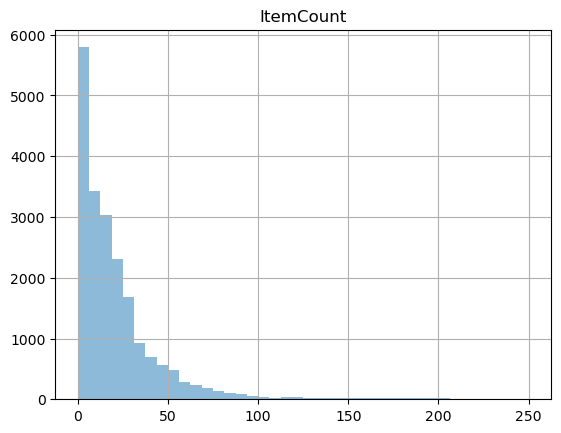

In [20]:
df2.hist(alpha=0.5, range=[0, 250], bins=40)
plt.show()

In [21]:
#We will look at a subset of the data for France.
basket1 = (df[df['Country'] =="France"]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

In [22]:
#convert each value into 0 or 1
basket_sets1 = basket1.applymap(encode_units)
basket_sets1.drop('POSTAGE', inplace=True, axis=1)

We can generate frequent item sets that have a support of at least x%:

In [36]:
#set thresholds for support, lift and confidence
min_support = 0.05
min_lift = 1 
min_confidence = 0.5 

In [37]:
frequent_itemsets1 = apriori(basket_sets1, min_support=min_support, use_colnames=True)

frequent_itemsets1.head(10)

,support,itemsets
0,0.071429,(4 TRADITIONAL SPINNING TOPS)
1,0.096939,(ALARM CLOCK BAKELIKE GREEN)
2,0.102041,(ALARM CLOCK BAKELIKE PINK)
3,0.094388,(ALARM CLOCK BAKELIKE RED)
4,0.068878,(ASSORTED COLOUR MINI CASES)
5,0.081633,(BAKING SET 9 PIECE RETROSPOT)
6,0.051020,(BLUE HARMONICA IN BOX)
7,0.068878,(CHARLOTTE BAG APPLES DESIGN)
8,0.066327,(CHARLOTTE BAG DOLLY GIRL DESIGN)
9,0.058673,(CHARLOTTE BAG PINK POLKADOT)


In [38]:
rules = association_rules(frequent_itemsets1, metric="lift", min_threshold=1)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE GREEN),0.102041,0.096939,0.073980,0.725000,7.478947,0.064088,3.283859
1,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE PINK),0.096939,0.102041,0.073980,0.763158,7.478947,0.064088,3.791383
2,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.096939,0.094388,0.079082,0.815789,8.642959,0.069932,4.916181
3,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.094388,0.096939,0.079082,0.837838,8.642959,0.069932,5.568878
4,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE RED),0.102041,0.094388,0.073980,0.725000,7.681081,0.064348,3.293135


In [39]:
rules[ (rules['lift'] >= min_lift) &
       (rules['confidence'] >= min_confidence) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE GREEN),0.102041,0.096939,0.073980,0.725000,7.478947,0.064088,3.283859
1,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE PINK),0.096939,0.102041,0.073980,0.763158,7.478947,0.064088,3.791383
2,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.096939,0.094388,0.079082,0.815789,8.642959,0.069932,4.916181
3,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.094388,0.096939,0.079082,0.837838,8.642959,0.069932,5.568878
4,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE RED),0.102041,0.094388,0.073980,0.725000,7.681081,0.064348,3.293135
5,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE PINK),0.094388,0.102041,0.073980,0.783784,7.681081,0.064348,4.153061
7,(ALARM CLOCK BAKELIKE RED),(ROUND SNACK BOXES SET OF4 WOODLAND),0.094388,0.158163,0.051020,0.540541,3.417611,0.036092,1.832233
8,(CHILDRENS CUTLERY DOLLY GIRL),(CHILDRENS CUTLERY SPACEBOY),0.071429,0.068878,0.063776,0.892857,12.962963,0.058856,8.690476
9,(CHILDRENS CUTLERY SPACEBOY),(CHILDRENS CUTLERY DOLLY GIRL),0.068878,0.071429,0.063776,0.925926,12.962963,0.058856,12.535714
10,(DOLLY GIRL LUNCH BOX),(SPACEBOY LUNCH BOX),0.099490,0.125000,0.071429,0.717949,5.743590,0.058992,3.102273


In [28]:
basket2 = (df[df['Country'] =="Germany"]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

basket_sets2 = basket2.applymap(encode_units)
basket_sets2.drop('POSTAGE', inplace=True, axis=1)
frequent_itemsets2 = apriori(basket_sets2, min_support=0.05, use_colnames=True)
rules2 = association_rules(frequent_itemsets2, metric="lift", min_threshold=1)

rules2[ (rules2['lift'] >= min_lift) &
        (rules2['confidence'] >= min_confidence)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(PLASTERS IN TIN CIRCUS PARADE),(PLASTERS IN TIN WOODLAND ANIMALS),0.115974,0.137856,0.067834,0.584906,4.242887,0.051846,2.076984
1,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN CIRCUS PARADE),0.137856,0.115974,0.067834,0.492063,4.242887,0.051846,1.740427
2,(ROUND SNACK BOXES SET OF 4 FRUITS),(PLASTERS IN TIN CIRCUS PARADE),0.157549,0.115974,0.050328,0.319444,2.754455,0.032057,1.298977
3,(PLASTERS IN TIN CIRCUS PARADE),(ROUND SNACK BOXES SET OF 4 FRUITS),0.115974,0.157549,0.050328,0.433962,2.754455,0.032057,1.488330
4,(PLASTERS IN TIN CIRCUS PARADE),(ROUND SNACK BOXES SET OF4 WOODLAND),0.115974,0.245077,0.056893,0.490566,2.001685,0.028470,1.481887
5,(ROUND SNACK BOXES SET OF4 WOODLAND),(PLASTERS IN TIN CIRCUS PARADE),0.245077,0.115974,0.056893,0.232143,2.001685,0.028470,1.151290
6,(PLASTERS IN TIN SPACEBOY),(PLASTERS IN TIN WOODLAND ANIMALS),0.107221,0.137856,0.061269,0.571429,4.145125,0.046488,2.011670
7,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN SPACEBOY),0.137856,0.107221,0.061269,0.444444,4.145125,0.046488,1.607002
8,(ROUND SNACK BOXES SET OF4 WOODLAND),(PLASTERS IN TIN WOODLAND ANIMALS),0.245077,0.137856,0.074398,0.303571,2.202098,0.040613,1.237951
9,(PLASTERS IN TIN WOODLAND ANIMALS),(ROUND SNACK BOXES SET OF4 WOODLAND),0.137856,0.245077,0.074398,0.539683,2.202098,0.040613,1.640006


In [ ]:
#Implement the FPGrowth algorithm and measure performance 